In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
sns.set("talk")

### First, general wage gaps

In [3]:
df = pd.read_csv("../data/master_dataset_gender-1990-2019_1-16.csv")

In [4]:
def get_outcome_only_ratio(df, method):
    female = df[df['female'] == 1]
    if method == 'r_learner':
        return np.exp(np.average(female['r_learner_pred'], weights=female['famwgt']))
    else:
        return np.exp(np.average(female[f'{method}_female_pred'] - female[f'{method}_male_pred'], weights=female['famwgt']))

In [5]:
def get_aipw_ratio(df, outcome_type, prop_type):
  aipw_numerator = np.average((df['female'] - (1 - df['female']) * df[f'{prop_type}_prop_score'] / (1 - df[f'{prop_type}_prop_score'])) * (df['lnwage'] - df[f'{outcome_type}_male_pred']), weights=df['famwgt'])
  aipw_denominator = np.average(df['female'], weights=df['famwgt'])
  return np.exp(aipw_numerator / aipw_denominator)

In [6]:
def get_r_learner_objective(df, model_name):
    df = df.copy()
    df['marginalized_residual'] = df['lnwage'] - df['wage_model_marginalize_treatment_pred']
    df['propensity_residual'] = df['treatment'] - df['propensity_model_prop_score']
    if model_name != 'r_learner':
        df[f'{model_name}_diff'] = df[f'{model_name}_female_pred'] - df[f'{model_name}_male_pred']
    else:
        df[f'{model_name}_diff'] = df[f'{model_name}_pred']
    r_learner_weighted_score = np.average(
      (df['marginalized_residual']- (df['propensity_residual'] * df[f'{model_name}_diff'])) ** 2,
      weights=df['famwgt']
    )
    return r_learner_weighted_score.item()

In [7]:
def bootstrap_ratio_only(df, models, n_bootstrap=1000):
    true_means = {
        'outcome_only': {},
        'raw_ratio': None
    }
    for model in models:
        true_means['outcome_only'][model] = get_outcome_only_ratio(df, model)
    true_means['raw_ratio'] = np.exp(np.average(df[df['female'] == 1]['lnwage'], weights=df[df['female'] == 1]['famwgt']) - np.average(df[df['female'] == 0]['lnwage'], weights=df[df['female'] == 0]['famwgt']))
    
    results = {
        'outcome_only': {model: [] for model in models},
        'raw_ratio': []
    }
    n_samples = len(df)
    rs = np.random.RandomState(42)
    for _ in tqdm(range(n_bootstrap)):
        bootstrap_indices = rs.choice(n_samples, size=n_samples, replace=True)
        bootstrap_df = df.iloc[bootstrap_indices]
        for model in models:
            results['outcome_only'][model].append(get_outcome_only_ratio(bootstrap_df, model))
        results['raw_ratio'].append(np.exp(np.average(bootstrap_df[bootstrap_df['female'] == 1]['lnwage'], weights=bootstrap_df[bootstrap_df['female'] == 1]['famwgt']) - np.average(bootstrap_df[bootstrap_df['female'] == 0]['lnwage'], weights=bootstrap_df[bootstrap_df['female'] == 0]['famwgt'])))
    return results, true_means


In [8]:
def bootstrap_estimates(df, models, aipw_models, n_bootstrap=1000):
    true_means = {
        'outcome_only': {},
        'r_learner_obj': {},
        'aipw': {},
        'raw_ratio': None,
        'r_learner_improvement_over_dbft': {},
    }
    for model in models:
        true_means['outcome_only'][model] = get_outcome_only_ratio(df, model)
        true_means['r_learner_obj'][model] = get_r_learner_objective(df, model)
        true_means['r_learner_improvement_over_dbft'][model] = true_means['r_learner_obj']['r_learner'] - true_means['r_learner_obj'][model]
    for outcome, prop in aipw_models:
        true_means['aipw'][f"{outcome}_{prop}"] = get_aipw_ratio(df, outcome, prop)
    true_means['raw_ratio'] = np.exp(np.average(df[df['female'] == 1]['lnwage'], weights=df[df['female'] == 1]['famwgt']) - np.average(df[df['female'] == 0]['lnwage'], weights=df[df['female'] == 0]['famwgt']))
    # Now bootstrap results
    results = {
        'outcome_only': {model: [] for model in models},
        'r_learner_obj': {model: [] for model in models},
        'aipw': {f"{outcome}_{prop}": [] for outcome, prop in aipw_models},
        'raw_ratio': [],
        'r_learner_improvement_over_dbft': {model: [] for model in models}
    }
    
    n_samples = len(df)
    rs = np.random.RandomState(42)
    for _ in tqdm(range(n_bootstrap)):
        # Sample with replacement
        bootstrap_indices = rs.choice(n_samples, size=n_samples, replace=True)
        bootstrap_df = df.iloc[bootstrap_indices]
        
        # Calculate metrics for each model
        for model in models:
            # Outcome only ratio
            results['outcome_only'][model].append(
                get_outcome_only_ratio(bootstrap_df, model)
            )
            # R-learner objective
            results['r_learner_obj'][model].append(
                get_r_learner_objective(bootstrap_df, model)
            )
            # R-learner improvement over regression
            results['r_learner_improvement_over_dbft'][model].append(
                results['r_learner_obj']['r_learner'][-1] - results['r_learner_obj'][model][-1]
            )
        # Also get the raw ratio
        female = bootstrap_df[bootstrap_df['female'] == 1]
        male = bootstrap_df[bootstrap_df['female'] == 0]
        results['raw_ratio'].append(np.exp(np.average(female['lnwage'], weights=female['famwgt']) - np.average(male['lnwage'], weights=male['famwgt'])))
        
        # Calculate AIPW ratios
        for outcome, prop in aipw_models:
            results['aipw'][f"{outcome}_{prop}"].append(
                get_aipw_ratio(bootstrap_df, outcome, prop)
            )
    
    return results, true_means

In [9]:
clipping_threshold = 0.01
n_bootstrap = 100
clipped_df = df[(df['propensity_model_prop_score'] > clipping_threshold) & (df['propensity_model_prop_score'] < 1 - clipping_threshold)]
models = ['r_learner', 'coarse_grained_regression', 'wage_model', 'dragonnet', 'round-2-wage']
aipw_models = [['coarse_grained_regression', 'coarse_grained_regression'],
               ['wage_model', 'propensity_model'],
               ['dragonnet', 'dragonnet'],
               ['round-2-wage', 'round-1-prop']]

bootstrap_results, true_means = bootstrap_estimates(clipped_df, models, aipw_models, n_bootstrap=n_bootstrap)


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


In [10]:
# Create lists to store the data
rows = []

# Process each metric type (outcome_only, r_learner_obj, etc.)
metrics_for_table = [metric for metric in bootstrap_results.keys()]
# for metric_type in bootstrap_results.keys():
for metric_type in metrics_for_table:
    if metric_type == 'raw_ratio':
        # Handle raw_ratio separately since it doesn't have model names
        mean_val = true_means[metric_type]
        bootstrap_vals = bootstrap_results[metric_type]
        std_error = np.std(bootstrap_vals)
        rows.append({
            'metric_type': metric_type,
            'model': 'raw',
            'mean': mean_val,
            'std_error': std_error
        })
    else:
        # Handle other metrics that have model names
        for model in bootstrap_results[metric_type].keys():
            mean_val = true_means[metric_type][model]
            bootstrap_vals = bootstrap_results[metric_type][model]
            std_error = np.std(bootstrap_vals)
            rows.append({
                'metric_type': metric_type,
                'model': model,
                'mean': mean_val,
                'std_error': std_error
            })


#### The data in the next cell makes Table S5 and Table 2

Metric type outcome-only and AIPW. 
For outcome-only, linear regression is the model `coarse_grained_regression`, multi-task fine-tuning is `dragonnet`, projection fine-tuning is `round-2-wage`. 
For AIPW, linear regression is the model `coarse_grained_regression_coarse_grained_regression`, multi-task fine-tuning is `dragonnet_dragonnet`, projection fine-tuning is `round-2-wage_round-1-prop`.	

In [12]:
# Create DataFrame
results_df = pd.DataFrame(rows)

# Define custom sort orders
metric_order = ['raw_ratio', 'outcome_only', 'r_learner_obj', 'r_learner_improvement_over_dbft', 'aipw']
model_order = ['coarse_grained_regression', 'wage_model', 'dragonnet', 'round-2-wage', 'r_learner', 
               'coarse_grained_regression_coarse_grained_regression', 
               'wage_model_propensity_model',
               'dragonnet_dragonnet',
               'round-2-wage_round-1-prop']

# Convert to categorical with custom orders
results_df['metric_type'] = pd.Categorical(results_df['metric_type'], categories=metric_order, ordered=True)
results_df['model'] = pd.Categorical(results_df['model'], categories=model_order + ['raw'], ordered=True)

# Sort by metric_type first, then model
results_df = results_df.sort_values(['metric_type', 'model'])
results_df[['mean', 'std_error']] = results_df[['mean', 'std_error']].round(4)

# Display the results
results_df

,metric_type,model,mean,std_error
14,raw_ratio,raw,0.7754,0.0045
1,outcome_only,coarse_grained_regression,0.8856,0.0008
2,outcome_only,wage_model,0.9093,0.0007
3,outcome_only,dragonnet,0.9067,0.0008
4,outcome_only,round-2-wage,0.9043,0.0007
0,outcome_only,r_learner,0.9336,0.0003
6,r_learner_obj,coarse_grained_regression,0.1841,0.0019
7,r_learner_obj,wage_model,0.1832,0.0019
8,r_learner_obj,dragonnet,0.1835,0.0019
9,r_learner_obj,round-2-wage,0.1833,0.0019


### Different clipping thresholds

In [13]:
clipping_thresholds = [0.00, 0.01, 0.025, 0.05]
n_bootstrap = 100
results_dict = {}

for clipping_threshold in clipping_thresholds:
    # Get clipped data
    clipped_df = df[(df['propensity_model_prop_score'] > clipping_threshold) & 
                    (df['propensity_model_prop_score'] < 1 - clipping_threshold)]
    
    # Store sample size (no std error needed)
    results_dict[f'n_samples_{clipping_threshold}'] = (len(clipped_df), 0)
    
    # Get raw gap and its bootstrap std error
    bootstrap_results, true_means = bootstrap_ratio_only(clipped_df, models, n_bootstrap=n_bootstrap)
    raw_gap_std = np.std(bootstrap_results['raw_ratio'])
    results_dict[f'raw_gap_{clipping_threshold}'] = (true_means['raw_ratio'], raw_gap_std)
    
    # Store results and std errors for each model
    for model in models:
        model_std = np.std(bootstrap_results['outcome_only'][model])
        results_dict[f'{model}_{clipping_threshold}'] = (true_means['outcome_only'][model], model_std)


100%|██████████| 100/100 [00:32<00:00,  3.06it/s]


#### The data in the next cell makes Table S4


In [15]:
# Create name mapping dictionary
name_map = {
    'n_samples': 'Data size',
    'raw_gap': 'Raw wage ratio',
    'coarse_grained_regression': 'Linear regression',
    'wage_model': 'Supervised fine-tuning',
    'dragonnet': 'Multi-task fine-tuning',
    'round-2-wage': 'Projection fine-tuning',
    'r_learner': 'Difference-based fine-tuning'
}

def format_entry(mean, std_error):
    return f"{mean:.3f} $\pm$ {std_error:.3f}"

# Create DataFrame with new names
results_df = pd.DataFrame({
    'metric': [name_map[x] for x in ['n_samples', 'raw_gap'] + models],
    '0.00': [format_entry(*results_dict[f'n_samples_0.0']),
             format_entry(*results_dict[f'raw_gap_0.0'])] + 
            [format_entry(*results_dict[f'{model}_0.0']) for model in models],
    '0.01': [format_entry(*results_dict[f'n_samples_0.01']),
             format_entry(*results_dict[f'raw_gap_0.01'])] + 
            [format_entry(*results_dict[f'{model}_0.01']) for model in models],
    '0.025': [format_entry(*results_dict[f'n_samples_0.025']),
              format_entry(*results_dict[f'raw_gap_0.025'])] + 
             [format_entry(*results_dict[f'{model}_0.025']) for model in models],
    '0.05': [format_entry(*results_dict[f'n_samples_0.05']),
             format_entry(*results_dict[f'raw_gap_0.05'])] + 
            [format_entry(*results_dict[f'{model}_0.05']) for model in models]
})

# Convert to LaTeX
latex_table = results_df.to_latex(index=False, 
                                 column_format='lcccc',
                                 escape=False,
                                 header=[' ', '0.00', '0.01', '0.025', '0.05'])

# Add the multicolumn header
header_addition = """\\toprule
& \\multicolumn{4}{c}{Propensity score clipping threshold} \\\\
\\midrule
"""

# Insert the multicolumn header after the first line of the latex table
latex_lines = latex_table.split('\n')
latex_lines.insert(1, header_addition)
latex_table = '\n'.join(latex_lines)

print(latex_table)

\begin{tabular}{lcccc}
\toprule
& \multicolumn{4}{c}{Propensity score clipping threshold} \\
\midrule

\toprule
  & 0.00 & 0.01 & 0.025 & 0.05 \\
\midrule
Data size & 91568.000 $\pm$ 0.000 & 77098.000 $\pm$ 0.000 & 64282.000 $\pm$ 0.000 & 53618.000 $\pm$ 0.000 \\
Raw wage ratio & 0.771 $\pm$ 0.004 & 0.775 $\pm$ 0.004 & 0.781 $\pm$ 0.005 & 0.792 $\pm$ 0.005 \\
Difference-based fine-tuning & 0.933 $\pm$ 0.000 & 0.934 $\pm$ 0.000 & 0.934 $\pm$ 0.000 & 0.934 $\pm$ 0.000 \\
Linear regression & 0.891 $\pm$ 0.001 & 0.886 $\pm$ 0.001 & 0.884 $\pm$ 0.001 & 0.880 $\pm$ 0.001 \\
Supervised fine-tuning & 0.913 $\pm$ 0.001 & 0.909 $\pm$ 0.001 & 0.910 $\pm$ 0.001 & 0.910 $\pm$ 0.001 \\
Multi-task fine-tuning & 0.907 $\pm$ 0.001 & 0.907 $\pm$ 0.001 & 0.909 $\pm$ 0.001 & 0.910 $\pm$ 0.001 \\
Projection fine-tuning & 0.905 $\pm$ 0.001 & 0.904 $\pm$ 0.001 & 0.905 $\pm$ 0.001 & 0.906 $\pm$ 0.001 \\
\bottomrule
\end{tabular}



### Wage gap by year

In [16]:
# Define year clusters and models we care about
year_clusters = [
    (1990, 1995),
    (1996, 2001),
    (2002, 2007),
    (2008, 2013),
    (2014, 2019)
]
models_subset = ['coarse_grained_regression', 'r_learner']

# Store results
results_by_year = {}
clipping_threshold = 0.01
n_bootstrap = 100

for start_year, end_year in year_clusters:
    # Filter data for year range and clipping
    year_df = df[
        (df['year'] >= start_year) & 
        (df['year'] <= end_year) &
        (df['propensity_model_prop_score'] > clipping_threshold) & 
        (df['propensity_model_prop_score'] < 1 - clipping_threshold)
    ]
    
    # Get bootstrap results for this year range
    bootstrap_results, true_means = bootstrap_ratio_only(year_df, models_subset, n_bootstrap=n_bootstrap)
    
    # Store results
    results_by_year[f"{start_year}-{end_year}"] = {
        'raw_ratio': (true_means['raw_ratio'], np.std(bootstrap_results['raw_ratio'])),
        'regression': (true_means['outcome_only']['coarse_grained_regression'], 
                      np.std(bootstrap_results['outcome_only']['coarse_grained_regression'])),
        'r_learner': (true_means['outcome_only']['r_learner'],
                     np.std(bootstrap_results['outcome_only']['r_learner']))
    }

100%|██████████| 100/100 [00:05<00:00, 17.81it/s]


#### The next cell creates Fig S3.



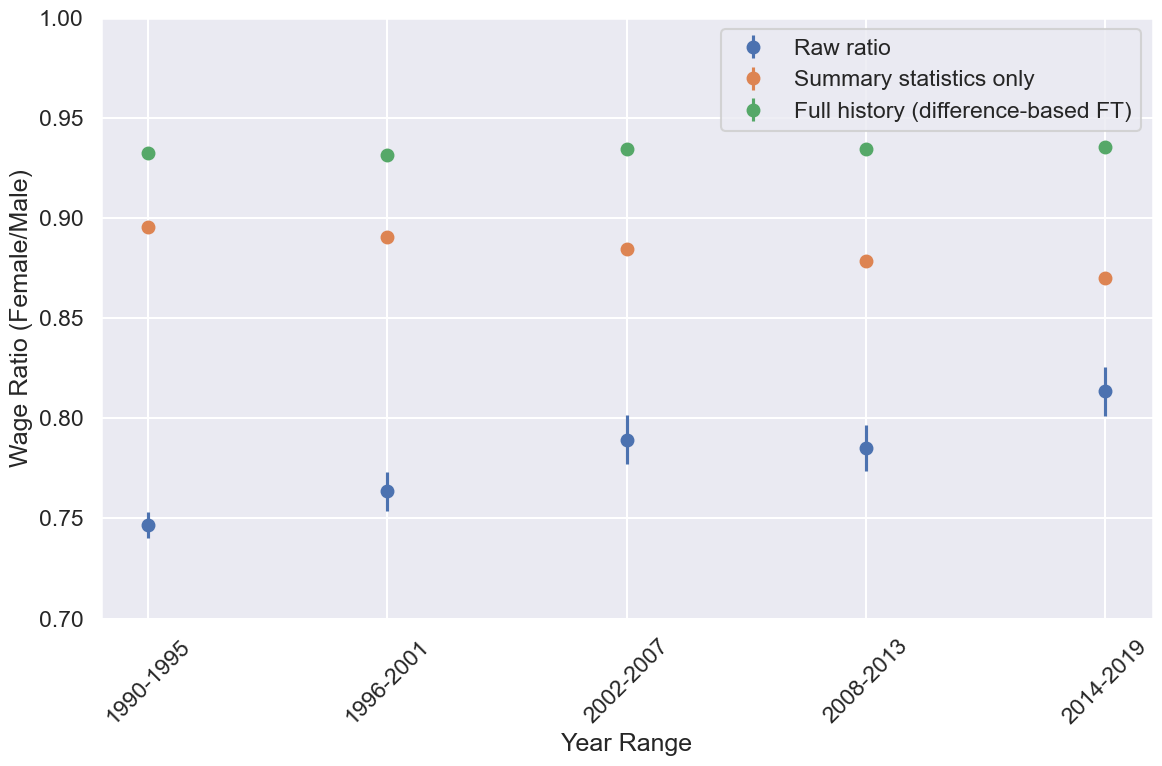

In [17]:
# Prepare data for plotting
sns.set("talk")
x_labels = list(results_by_year.keys())
x_positions = np.arange(len(x_labels))

# Create figure
plt.figure(figsize=(12, 8))

# Plot each method with different markers and colors
methods = {
    'raw_ratio': 'Raw ratio',
    'regression': 'Summary statistics only',
    'r_learner': 'Full history (difference-based FT)'
}

for method, label in methods.items():
    means = [results_by_year[year][method][0] for year in x_labels]
    errors = [results_by_year[year][method][1] for year in x_labels]
    
    plt.errorbar(x_positions, means, yerr=errors, 
                label=label, marker='o', linestyle='none')

plt.xlabel('Year Range')
plt.ylabel('Wage Ratio (Female/Male)')
# plt.title('Wage Ratios Over Time by Method')
plt.xticks(x_positions, x_labels, rotation=45)
# plt.grid(True, alpha=0.3)
plt.legend()

# Set y-axis limits to focus on the relevant range
plt.ylim(0.7, 1.0)

plt.tight_layout()
plt.savefig('../figs/wage_ratios_over_time.pdf', bbox_inches='tight', dpi=300)

### GWG by age

In [18]:
# First filter for 2014-2019
recent_df = df[(df['year'] >= 2014) & (df['year'] <= 2019)]

# Create age buckets (you can adjust these ranges)
age_buckets = [
    (25, 34),
    (35, 44),
    (45, 54),
    (55, 64)
]

# Store results
results_by_age = {}
clipping_threshold = 0.01
n_bootstrap = 100

for start_age, end_age in age_buckets:
    # Filter data for age range and clipping
    age_df = recent_df[
        (recent_df['age'] >= start_age) & 
        (recent_df['age'] <= end_age) &
        (recent_df['propensity_model_prop_score'] > clipping_threshold) & 
        (recent_df['propensity_model_prop_score'] < 1 - clipping_threshold)
    ]
    
    # Get bootstrap results for this age range
    bootstrap_results, true_means = bootstrap_ratio_only(age_df, ['coarse_grained_regression', 'r_learner'], n_bootstrap=n_bootstrap)
    
    # Store results
    results_by_age[f"{start_age}-{end_age}"] = {
        'raw_ratio': (true_means['raw_ratio'], np.std(bootstrap_results['raw_ratio'])),
        'regression': (true_means['outcome_only']['coarse_grained_regression'], 
                      np.std(bootstrap_results['outcome_only']['coarse_grained_regression'])),
        'r_learner': (true_means['outcome_only']['r_learner'],
                     np.std(bootstrap_results['outcome_only']['r_learner']))
    }


100%|██████████| 100/100 [00:00<00:00, 122.86it/s]


#### The next cell creates Fig S4.


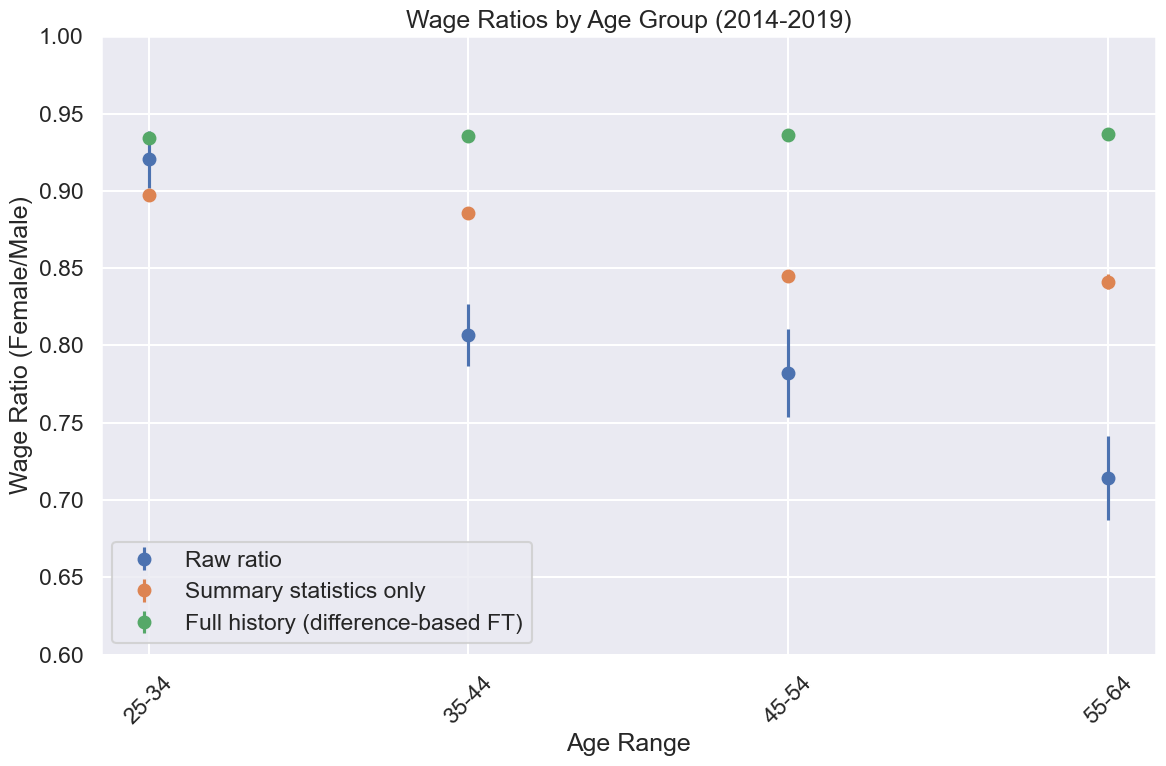

In [19]:
# Prepare data for plotting
x_labels = list(results_by_age.keys())
x_positions = np.arange(len(x_labels))

# Create figure
plt.figure(figsize=(12, 8))

# Plot each method with different markers and colors
methods = {
    'raw_ratio': 'Raw ratio',
    'regression': 'Summary statistics only',
    'r_learner': 'Full history (difference-based FT)'
}

for method, label in methods.items():
    means = [results_by_age[age][method][0] for age in x_labels]
    errors = [results_by_age[age][method][1] for age in x_labels]
    
    plt.errorbar(x_positions, means, yerr=errors, 
                label=label, marker='o', linestyle='none')

plt.xlabel('Age Range')
plt.ylabel('Wage Ratio (Female/Male)')
plt.title('Wage Ratios by Age Group (2014-2019)')
plt.xticks(x_positions, x_labels, rotation=45)
plt.legend()

# Set y-axis limits to focus on the relevant range
plt.ylim(0.6, 1.0)

plt.tight_layout()
plt.savefig('../figs/wage_ratios_by_age.pdf', bbox_inches='tight', dpi=300)
plt.show()

### By occupation

In [20]:
bk_jobs = np.array(['business', 'financialop', 'computer', 'architect', 'scientist', 'socialworker', 'postseceduc', 'legaleduc', 'artist', 'lawyerphysician', 'healthcare', 'healthsupport', 'protective', 'foodcare', 'building', 'sales', 'officeadmin', 'farmer', 'constructextractinstall', 'production', 'transport'])
bk_job_indicators = df[bk_jobs].values
assert bk_job_indicators.sum(0)[17] == 0.  # No farmers.
# Manager is the omitted job, so rows that sum to zero consist of managers.
manager_indicators = np.where(bk_job_indicators.sum(1) == 0, 1, 0)
bk_job_indicators[:, 17] = manager_indicators
bk_jobs[17] = 'manager'
assert all(bk_job_indicators.sum(-1) == 1)
# Find the column that is equal to 1 for each row.
bk_job_indicators = np.argmax(bk_job_indicators, axis=1)
df['bk_job_ind'] = bk_job_indicators

In [21]:
# Get ratios for each occupation
results_by_occupation = {}
clipping_threshold = 0.01
n_bootstrap = 100

for job_idx, job_name in enumerate(bk_jobs):
    # Filter data for occupation and clipping
    job_df = df[
        (df['bk_job_ind'] == job_idx) &
        (df['propensity_model_prop_score'] > clipping_threshold) & 
        (df['propensity_model_prop_score'] < 1 - clipping_threshold)
    ]
    
    if len(job_df) > 0:  # Only process if we have data for this occupation
        # Get bootstrap results for this occupation
        bootstrap_results, true_means = bootstrap_ratio_only(job_df, ['coarse_grained_regression', 'r_learner'], n_bootstrap=n_bootstrap)
        
        # Store results
        results_by_occupation[job_name] = {
            'regression': (true_means['outcome_only']['coarse_grained_regression'], 
                         np.std(bootstrap_results['outcome_only']['coarse_grained_regression'])),
            'r_learner': (true_means['outcome_only']['r_learner'],
                         np.std(bootstrap_results['outcome_only']['r_learner']))
        }

100%|██████████| 100/100 [00:01<00:00, 65.59it/s]


#### The next cell creates Fig S5.


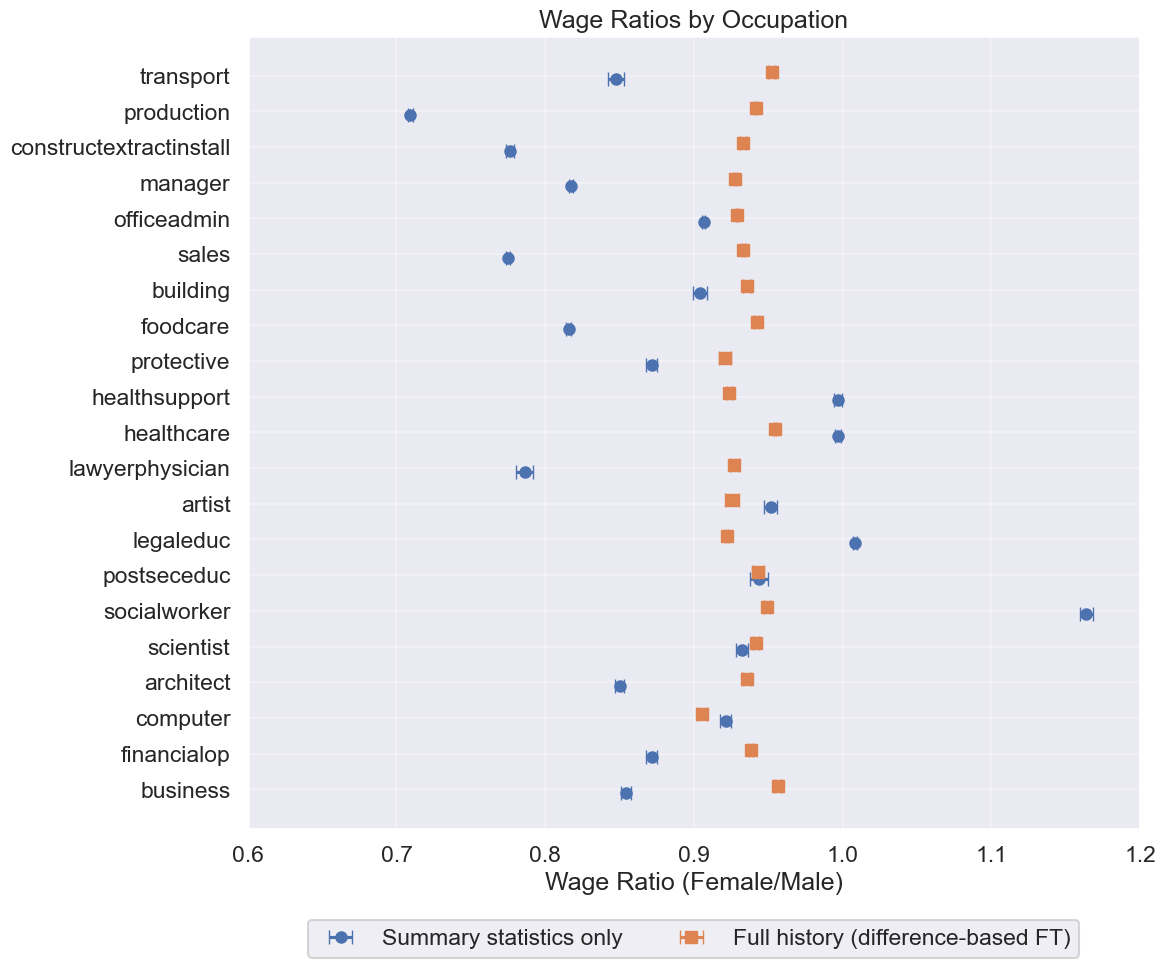

In [22]:

# Prepare data for plotting
occupations = list(results_by_occupation.keys())
y_positions = np.arange(len(occupations))

# Create figure
plt.figure(figsize=(12, 10))

# Plot each method
methods = {
    'regression': ('Summary statistics only', 'o'),
    'r_learner': ('Full history (difference-based FT)', 's')
}

for i, (method, (label, marker)) in enumerate(methods.items()):
    means = [results_by_occupation[occ][method][0] for occ in occupations]
    errors = [results_by_occupation[occ][method][1] for occ in occupations]
    
    plt.errorbar(means, y_positions + i*0.2 - 0.1, xerr=errors, 
                label=label, marker=marker, linestyle='none',
                capsize=5, markersize=8)

plt.yticks(y_positions, occupations)
plt.xlabel('Wage Ratio (Female/Male)')
plt.title('Wage Ratios by Occupation')
plt.grid(True, alpha=0.3)
plt.legend(
    bbox_to_anchor=(0.5, -0.1),  # Position legend below plot
    loc='upper center',           # Center it horizontally
    ncol=2                        # Put legend items in 2 columns
)


# Set x-axis limits to focus on the relevant range
plt.xlim(0.6, 1.2)

plt.tight_layout()
plt.savefig('../figs/wage_ratios_by_occupation.pdf', bbox_inches='tight', dpi=300)
plt.show()